In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
import sys

In [ ]:
MAX_CARS = 20
GAMMA = 0.9
CREDIT_REWARD = 10
MOVING_REWARD = -2
SECOND_PARKING_REWARD = -4

In [ ]:
class poisson_:
    def __init__(self, _lambda):
        self._lambda = _lambda
        epsilon = 0.01

        # [α , β] is the range of n's for which the pmf value is above epsilon
        self.alpha = 0
        state = 1
        self.vals = {}
        summer = 0
        
        while(1):
            if state == 1:
                temp = poisson.pmf(self.alpha, self._lambda) 
                if(temp <= epsilon):
                    self.alpha+=1
                else:
                    self.vals[self.alpha] = temp
                    summer += temp
                    self.beta = self.alpha+1
                    state = 2
            elif state == 2:
                temp = poisson.pmf(self.beta, self._lambda)
                if(temp > epsilon):
                    self.vals[self.beta] = temp
                    summer += temp
                    self.beta+=1
                else:
                    break    
        
        # normalizing the pmf, values of n outside of [α, β] have pmf = 0
        
        added_val = (1-summer)/(self.beta-self.alpha)
        for key in self.vals:
            self.vals[key] += added_val
        
            
    def f(self, n):
        try:
            Ret_value = self.vals[n]
        except(KeyError):
            Ret_value = 0
        finally:
            return Ret_value

In [ ]:
#A class holding the properties of a location together
class location:
    
    def __init__(self, req, ret):
        self.alpha = req                             #value of lambda for requests
        self.beta = ret                              #value of lambda for returns
        self.poisson_alpha = poisson_(self.alpha)
        self.poisson_beta = poisson_(self.beta)

In [ ]:
#Location initialisation

A = location(3,3)
B = location(4,2)

In [ ]:
#Initializing the value and policy matrices. Initial policy has zero value for all states.

value = np.zeros((MAX_CARS+1, MAX_CARS+1))
policy = value.copy().astype(int)

In [ ]:
def apply_action(state, action):
    return [max(min(state[0] - action, MAX_CARS),0) , max(min(state[1] + action, MAX_CARS),0)]

In [ ]:
def expected_reward(state, action):
    global value
    """
    state  : It's a pair of integers, # of cars at A and at B
    action : # of cars transferred from A to B,  -5 <= action <= 5 
    """
    
    
    psi = 0 #reward
    new_state = apply_action(state, action)    
    
    # adding reward for moving cars from one location to another (which is negative) 
    
    if action <= 0:
        psi = psi + MOVING_REWARD * abs(action)
    else:
        psi = psi + MOVING_REWARD * (action - 1)    #one car is moved by one of Jack's employees for free
    
    # adding reward for second parking lot (which is also negative)
    
    if new_state[0] > 10:
        psi = psi + SECOND_PARKING_REWARD
        
    if new_state[1] > 10:
        psi = psi + SECOND_PARKING_REWARD
    
    # there are four discrete random variables which determine the probability distribution of the reward and next state
    
    for A_alpha in range(A.poisson_alpha.alpha, A.poisson_alpha.beta):
        for B_alpha in range(B.poisson_alpha.alpha, B.poisson_alpha.beta):
            for A_beta in range(A.poisson_beta.alpha, A.poisson_beta.beta):
                for B_beta in range(B.poisson_beta.alpha, B.poisson_beta.beta):
                    """
                    A_alpha : sample of cars requested at location A
                    A_beta : sample of cars returned at location A
                    B_alpha : sample of cars requested at location B
                    B_beta : sample of cars returned at location B
                    zeta  : probability of this event happening
                    """
                    
                    # all four variables are independent of each other
                    zeta = A.poisson_alpha.vals[A_alpha] * B.poisson_alpha.vals[B_alpha] * A.poisson_beta.vals[A_beta] * B.poisson_beta.vals[B_beta]
                    
                    valid_requests_A = min(new_state[0], A_alpha)
                    valid_requests_B = min(new_state[1], B_alpha)
                    
                    rew = (valid_requests_A + valid_requests_B)*(CREDIT_REWARD)
                    
                    #calculating the new state based on the values of the four random variables
                    new_s = [0,0]
                    new_s[0] = max(min(new_state[0] - valid_requests_A + A_beta, MAX_CARS),0)
                    new_s[1] = max(min(new_state[1] - valid_requests_B + B_beta, MAX_CARS),0)
                    
                    #Bellman's equation
                    psi += zeta * (rew + GAMMA * value[new_s[0]][new_s[1]])
                    
    return psi


In [ ]:
def policy_evaluation():
    
    global value
    
    # here policy_evaluation has a static variable epsilonpsilon whose values decreases over time
    epsilon = policy_evaluation.epsilon
    
    policy_evaluation.epsilon /= 10 
    
    while(1):
        delta = 0
        
        for i in range(value.shape[0]):
            for j in range(value.shape[1]):
                # value[i][j] denotes the value of the state [i,j]
                
                old_val = value[i][j]
                value[i][j] = expected_reward([i,j], policy[i][j])
                
                delta = max(delta, abs(value[i][j] - old_val))

        if delta < epsilon:
            break

In [ ]:
#initial value of epsilonpsilon
policy_evaluation.epsilon = 50


In [ ]:
def policy_improvement():
    
    global policy
    
    policy_stable = True
    for i in range(value.shape[0]):
        for j in range(value.shape[1]):
            old_action = policy[i][j]
            
            max_act_val = None
            max_act = None
            
            tau_12 = min(i,5)       # if I have say 3 cars at the first location, then I can atmost move 3 from 1 to 2
            tau_21 = -min(j,5)      # if I have say 2 cars at the second location, then I can atmost move 2 from 2 to 1
            
            for act in range(tau_21,tau_12+1):
                sigma = expected_reward([i,j], act)
                if max_act_val == None:
                    max_act_val = sigma
                    max_act = act
                elif max_act_val < sigma:
                    max_act_val = sigma
                    max_act = act
                
            policy[i][j] = max_act
            
            if old_action!= policy[i][j]:
                policy_stable = False
    
    return policy_stable


In [ ]:
sns.color_palette("hls", 8)

def save_policy():
    save_policy.counter += 1
    ax = sns.heatmap(policy, linewidth=0.5, cmap="crest")
    ax.invert_yaxis()
    plt.savefig('policy'+str(save_policy.counter)+'.svg')
    plt.close()
    
def save_value():
    save_value.counter += 1
    ax = sns.heatmap(value, linewidth=0.5, cmap="crest")
    ax.invert_yaxis()
    plt.savefig('value'+ str(save_value.counter)+'.svg')
    plt.close()


In [ ]:
save_policy.counter = 0
save_value.counter = 0

In [ ]:
while(1):
    policy_evaluation()
    ρ = policy_improvement()
    save_value()
    save_policy()
    if ρ == True:
        break


Final policy: 



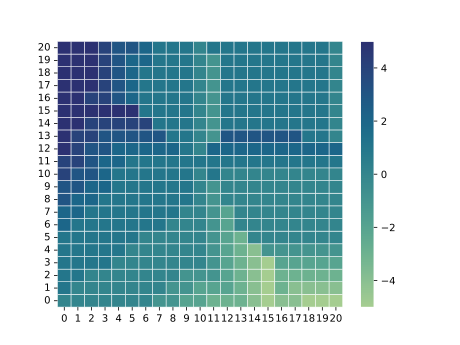

In [ ]:
from IPython.display import SVG, display

# for i in range (1, 6):
#   print("\n\nIteration count: ", i, "\n\n")
#   display(SVG("policy" + str(i) + ".svg"))
#   display(SVG("value" + str(i) + ".svg"))

print("\nFinal policy: \n")
display(SVG("policy5.svg"))

# print("\nFinal value function for policy: \n")
# display(SVG("value5.svg"))